In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../")

import builtins
builtins.NAMING = "new"


from plotting_src.header_settings import *
from plotting_src.read_ggp_run import * 
from simulations.cells_simulation import * 

from plotting_src.cells_utils import *
from plotting_src.read_utils import *


%config InlineBackend.figure_format ='retina'

header_setting.py: using new naming


In [2]:
def calc_log_concentration(cells):
    for i, cell in enumerate(cells):
        c = cell.gfp/np.exp(cell.log_length)
        if np.any(c<0):
            print(c)
        cells[i].log_concentration = np.log(c)
        cells[i].log1_concentration = np.log(c+1)
        cells[i].concentration = c
    return cells


def is_first_cell_in_lineage(cell, cells):
    pid = cell.parent_id
    for c in cells:
        if c.cell_id == pid:
            return False
    return True


def get_log_concentrations(cells):
    return np.concatenate([cell.log_concentration for cell in cells if not is_first_cell_in_lineage(cell, cells)])
    # return np.concatenate([cell.log_concentration for cell in cells ])



In [3]:
    hicolors = matplotlib.cm.get_cmap('tab20c')(np.arange(20))[8:12:2]
    medcolors = matplotlib.cm.get_cmap('tab20b')(np.arange(20))[13:17:2] 
    rcolors = matplotlib.cm.get_cmap('tab20b')(np.arange(20))[9:13:2] 
    hexs_promoters =  rgb_array_to_hex(np.concatenate([hicolors,medcolors,rcolors]))
    color_by_promoter = {p:c for p,c in zip(promoters, hexs_promoters)}

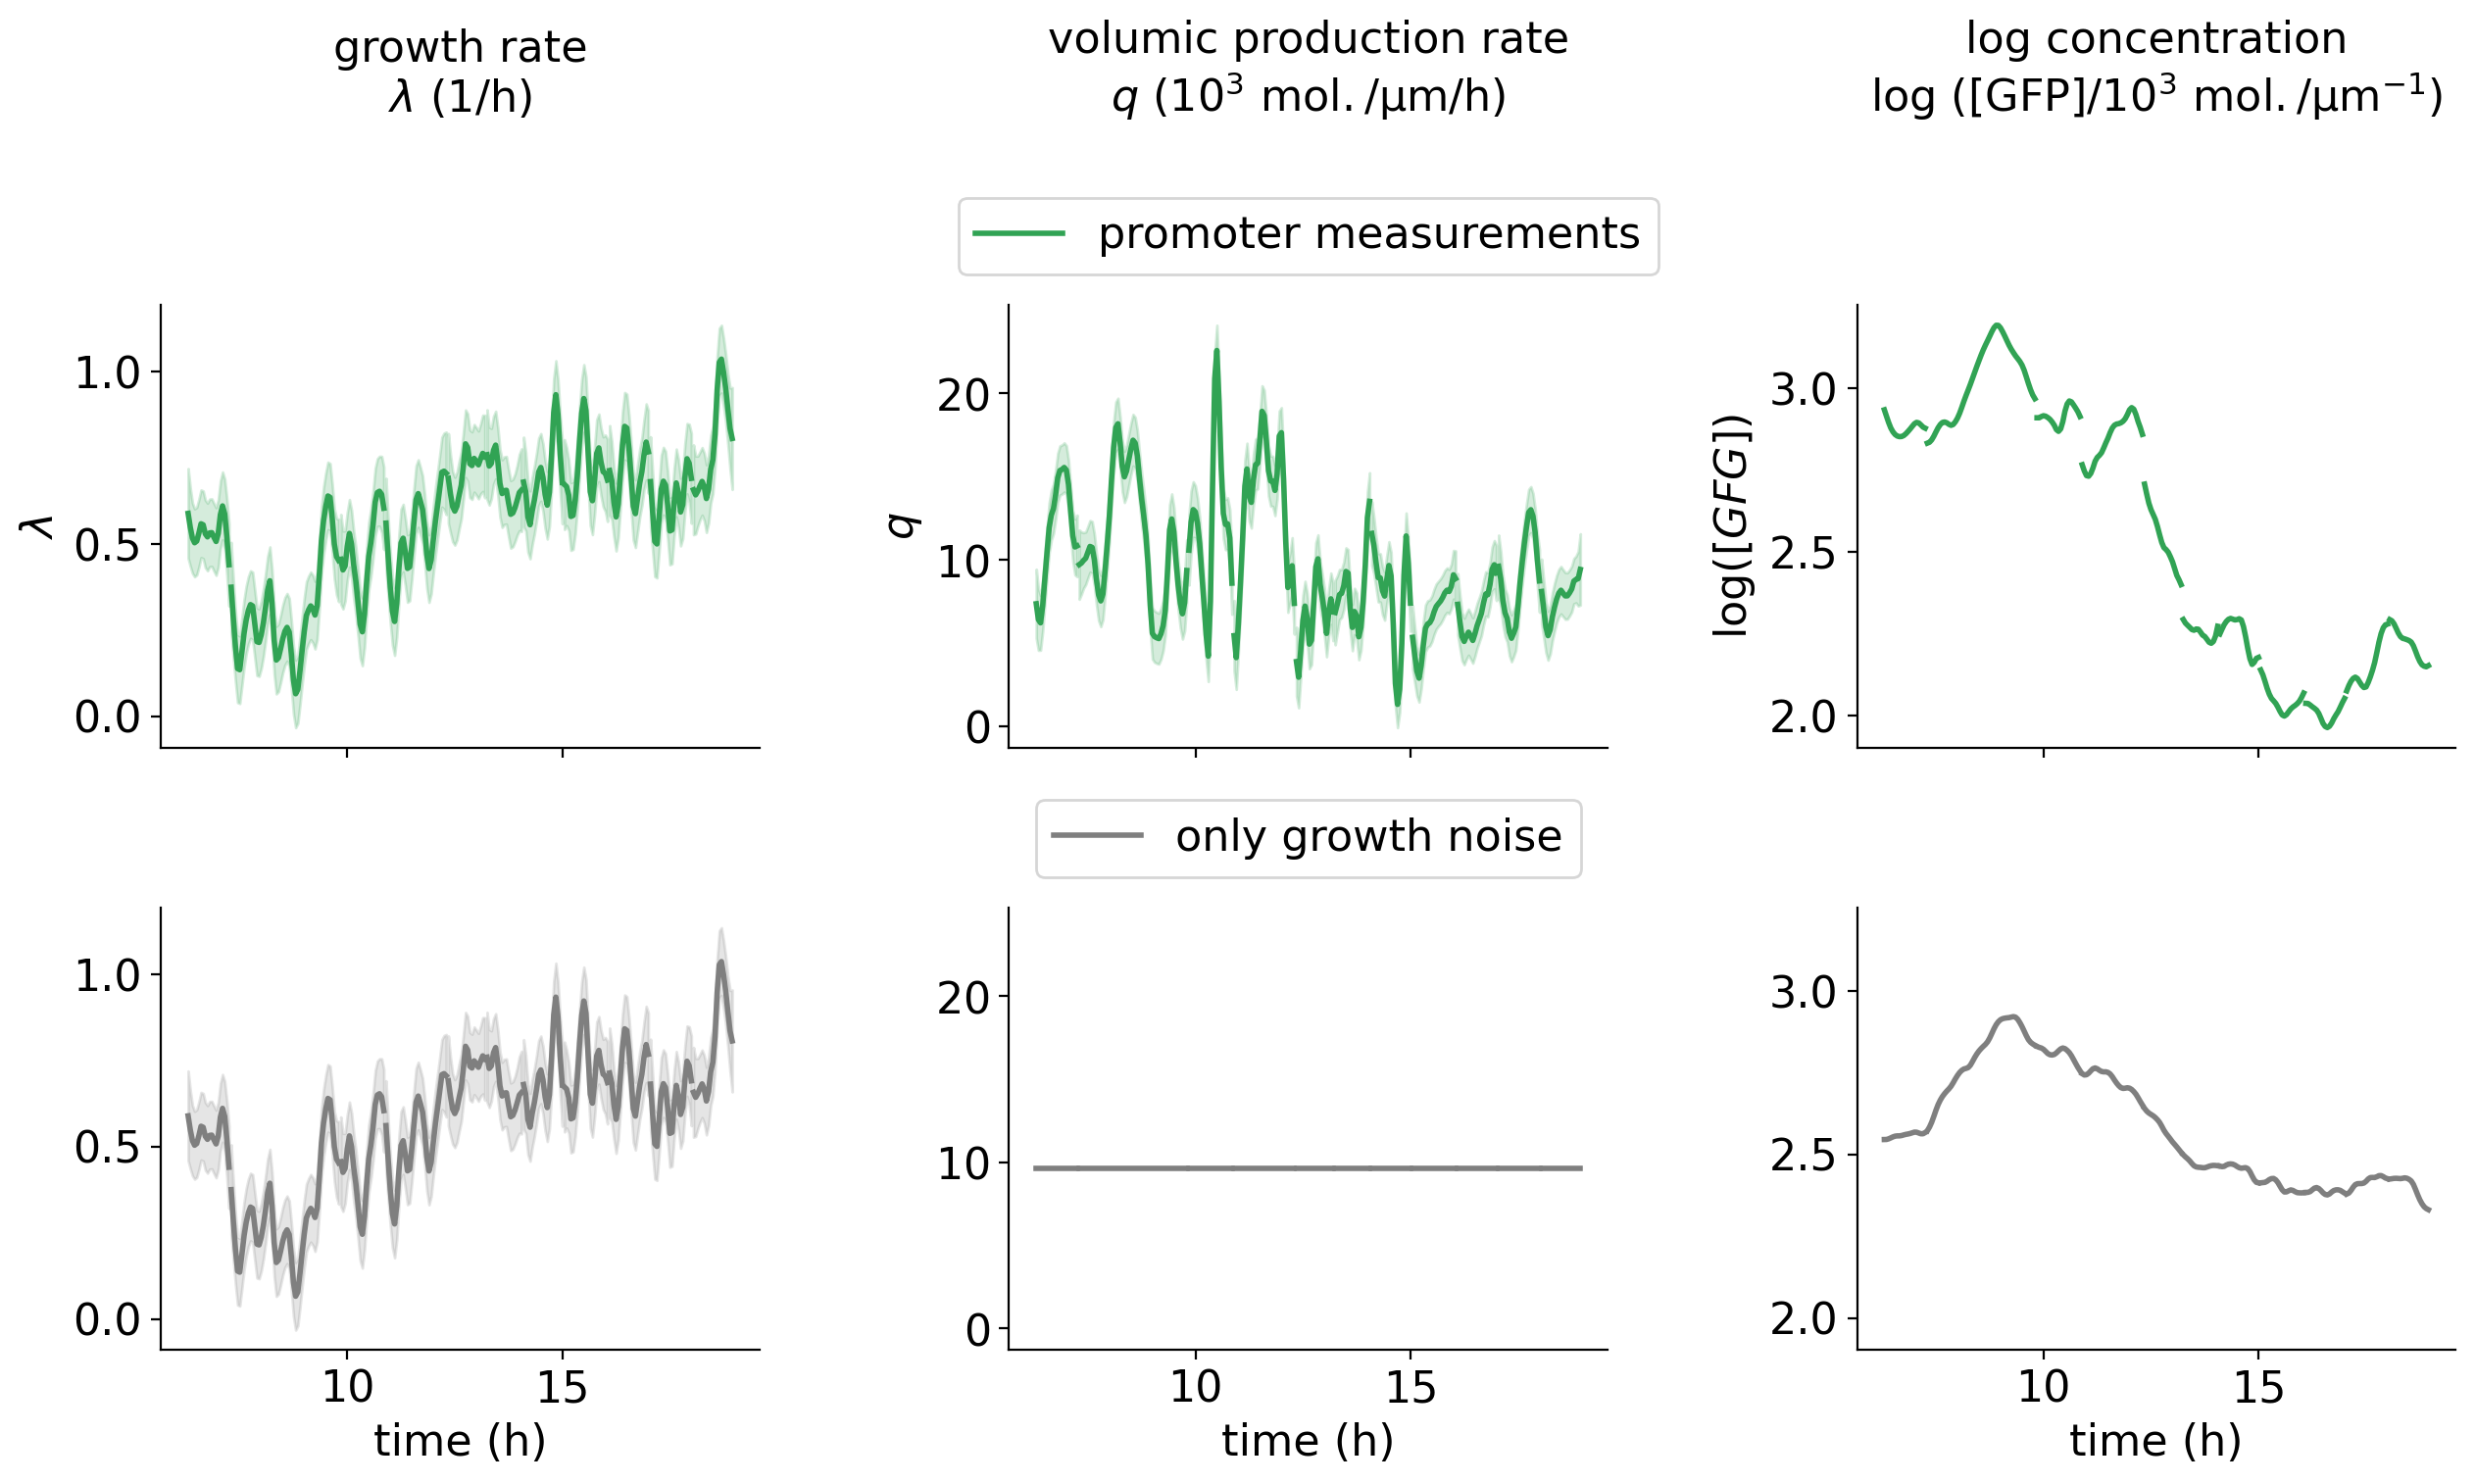

In [4]:


def plot_comparison_for_fig(cells_data, cells_integrated, cell_idx, time_unit=("h", 60), 
                           xlim=[None, None], 
                           plot_file=None, 
                           show=True, 
                           plot_integrated=True,
                           condition=None,
                           promoter=None,
                           color_by="condition",
                           ignore_errors=False, 
                           label=None,
                           iqr_text=r"$\mathrm{IQR_\lambda}$"):
                         
    fig, axes = plt.subplots(2, 3, figsize=(13, 8), sharex=True, sharey=False)

    ax = axes.ravel()

    s = 10
    lw = 2
    if plot_integrated:
        color_integrated = "tab:grey"
        label_integrated = label
    else:
        color_integrated = "None"
        label_integrated = None

    
    for i, cell_data in enumerate(cells_data):
        if i not in cell_idx:
            continue
        time = np.array(cell_data.time) / time_unit[1]
        cell_integrated = cells_integrated[i]

        if color_by=="both":
            color = color_by_both[promoter][condition]
        elif color_by=="promoter":
            color = color_by_promoter[promoter]
        elif color_by=="condition":
            color = color_by_condition[condition]
            
        # TOP
        ax[0].plot(time, np.array(cell_data.lt)*60, color=color, lw=lw, alpha=1)
        ax[0].fill_between(time, (cell_data.lt-np.sqrt(cell_data.cov_ll))*60, (cell_data.lt+np.sqrt(cell_data.cov_ll))*60, 
                    color=color, alpha=0.2)

        ax[1].plot(time, np.array(cell_data.qt)*60/1e3, color=color, lw=lw, alpha=1, label="promoter measurements")
        ax[1].fill_between(time, (cell_data.qt-np.sqrt(cell_data.cov_qq))*60/1e3, (cell_data.qt+np.sqrt(cell_data.cov_qq))*60/1e3, 
                    color=color, alpha=0.2)
        
        ax[2].plot(time, cell_data.log_concentration- np.log(1e3), color=color, lw=lw, alpha=1)
        
        
        # BOTTOM
        ax[3].plot(time, np.array(cell_data.lt)*60, color=color_integrated, lw=lw, alpha=1)
        ax[3].fill_between(time, (cell_data.lt-np.sqrt(cell_data.cov_ll))*60, (cell_data.lt+np.sqrt(cell_data.cov_ll))*60, 
                    color=color_integrated, alpha=0.2)
        
        ax[4].plot(time, np.array(cell_integrated.qt)*60/1e3, color=color_integrated,lw=lw, alpha=1,label="only growth noise")
                                        

        lc = cell_integrated.log_concentration
                
        
        ax[5].plot(time, cell_integrated.log_concentration- np.log(1e3), color=color_integrated, lw=lw, alpha=1)
                


        
    for i in range(6):
        ax[i].set_xlim(xlim)
        ax[i].xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=5))
        
    for i in range(3):
        ax[i+3].set_ylim(ax[i].get_ylim())

    # ax[1].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=10000))
    ax[2].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=0.5))
            
    ax[0].set_title("growth rate\n$\lambda$ (1/h)", y=1.4)   
    ax[1].set_title("volumic production rate\n$q$ $\mathrm{(10^3\ mol./\mu m/h)}$", y=1.4)   
    ax[2].set_title("log concentration\nlog ([GFP]$/\mathrm{10^3\ mol. /\mu m^{-1}}$)", y=1.4)   

    ax[3].set_xlabel("time ({:s})".format(time_unit[0]))  
    ax[4].set_xlabel("time ({:s})".format(time_unit[0]))  
    ax[5].set_xlabel("time ({:s})".format(time_unit[0]))      
    
    ax[1].ticklabel_format(axis='y', style='scientific', scilimits=[-2,2], useMathText=True)
    ax[4].ticklabel_format(axis='y', style='scientific', scilimits=[-2,2], useMathText=True)


    ax[0].set_ylabel("$\lambda$")
    ax[1].set_ylabel("$q$")
    ax[2].set_ylabel("$\log([GFG])$")

    # fig.legend(*legend_without_duplicate_labels(ax[3]), loc='lower center', bbox_to_anchor=(0.5, 1.02), ncol=2)
    ax[1].legend(*legend_without_duplicate_labels(ax[1]), loc='lower center', bbox_to_anchor=(0.5, 1.02), ncol=1)
    ax[4].legend(*legend_without_duplicate_labels(ax[4]), loc='lower center', bbox_to_anchor=(0.5, 1.02), ncol=1)

    fig.tight_layout(pad=1)


    for a in list(ax):
        a.spines["top"].set_visible(False)
        a.spines["right"].set_visible(False)
        a.spines['right'].set_color('none')
        a.yaxis.tick_left()

        a.spines['top'].set_color('none')
        a.xaxis.tick_bottom()        
    

    if plot_file != None:
        plt.show()
        fig.savefig(plot_file, bbox_inches='tight')
    elif show:
        plt.show()


sample = "glucose020_hi1_20190515"
# sample = "glucose020_hi3_20190529"
filename = "../../fluctuations_paper_data/mother_machine_data_sets/{:s}_autofl_corrected_f01234578910_b_prediction.csv"
cells_data = calc_log_concentration(ggp_df2cells(read_ggp_csv(filename.format(sample))))


filename = "../../fluctuations_paper_data/integration/{:s}/no_div_no_prod_noise/{:s}_no_div_no_prod_noise.csv"
cells_integrated = calc_log_concentration(df2cells(read_ggp_csv(filename.format(sample, sample)), qt="qt"))

path = [152, 155, 158, 166, 170, 173, 175, 121, 124, 129, 132, 135][1:]


plot_comparison_for_fig(cells_data, 
                                cells_integrated,
                                # get_all_paths(cells_data, n=11)[i][0:11], 
                                path,
                                condition=get_condition(sample),
                                promoter=get_promoter(sample),
                                color_by = "promoter",
                                ignore_errors=True, 
                                plot_integrated=True, 
                                label="only growth noise", 
                                iqr_text=r"$\eta_C$(only growth noise)",)
                                # plot_file="../../figures_for_fluctuations_paper/glucose_hi1_only_growth_noise_traces.pdf")

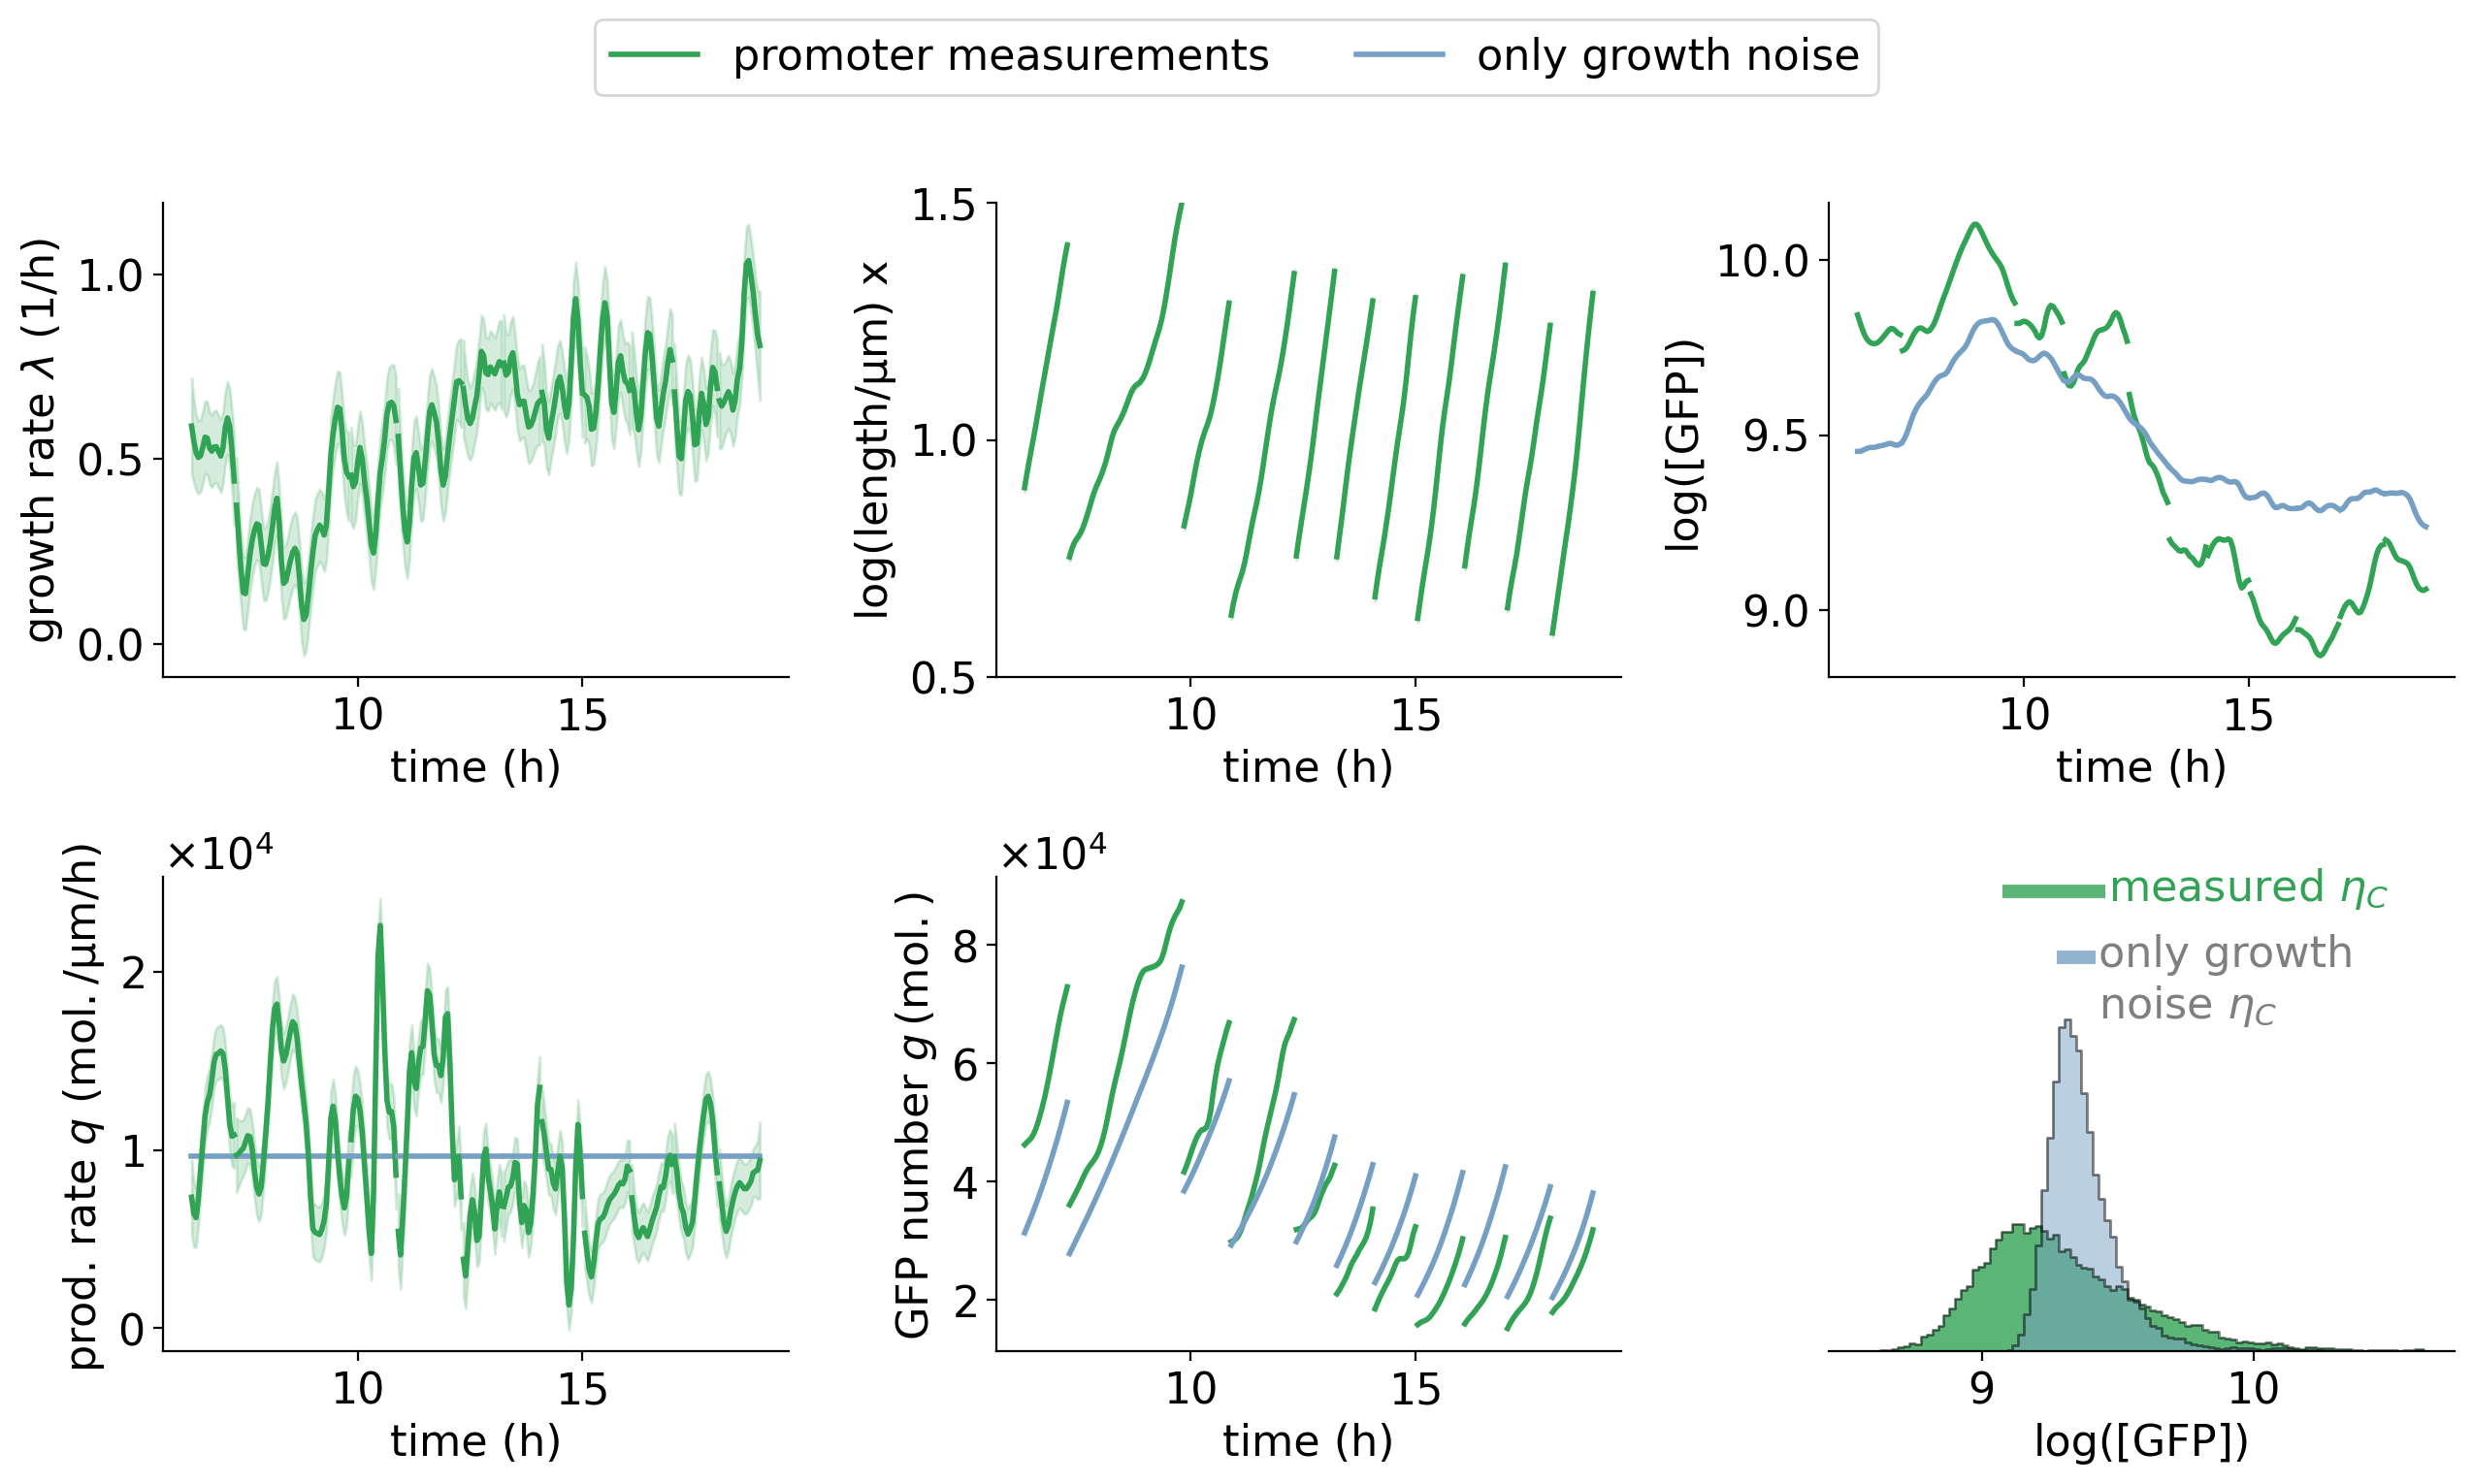

In [5]:
def bin_with_error_bars(means, variances, n_bins=1000, return_edges=True, ignore_errors=False):
    if ignore_errors:
        return np.histogram(means, bins="auto")
    left = np.min(means) - 2*np.sqrt(variances[np.argmin(means)])
    right = np.max(means) + 2*np.sqrt(variances[np.argmax(means)])
    
    _,bin_edges = np.histogram(means, bins=np.linspace(left, right, n_bins))
    
    bin_c = bin_edges[:-1] +np.diff(bin_edges)/2
    weight = np.zeros_like(bin_c)
    for i, m in enumerate(means):
        weight += special.erf( (bin_edges[1:]-m)/np.sqrt(2*variances[i]) ) - special.erf( (bin_edges[:-1]-m)/np.sqrt(2*variances[i]) )
    if return_edges:
        return weight, bin_edges
    else:
        return weight, bin_c



def plot_predictions_vs_inegration(cells_data, cells_integrated, cell_idx, time_unit=("h", 60), 
                           xlim=[None, None], 
                           plot_file=None, 
                           show=True, 
                           plot_integrated=True,
                           condition=None,
                           promoter=None,
                           color_by="condition",
                           ignore_errors=False, 
                           label=None,
                           iqr_text=r"$\mathrm{IQR_\lambda}$"):
                         
    fig, axes = plt.subplots(2, 3, figsize=(13, 7), sharex=False, sharey=False)

    axes = axes.transpose()
    ax = axes.ravel()

    s = 10
    lw = 2
    if plot_integrated:
        color_integrated = color_by_condition[conditions[2]]
        label_integrated = label
    else:
        color_integrated = "None"
        label_integrated = None

    
    for i, cell_data in enumerate(cells_data):
        if i not in cell_idx:
            continue
        time = np.array(cell_data.time) / time_unit[1]
        cell_integrated = cells_integrated[i]

        if color_by=="both":
            color = color_by_both[promoter][condition]
        elif color_by=="promoter":
            color = color_by_promoter[promoter]
        elif color_by=="condition":
            color = color_by_condition[condition]
            
        
        ax[0].plot(time, np.array(cell_data.lt)*60, color=color, lw=lw, alpha=1)
        ax[0].fill_between(time, (cell_data.lt-np.sqrt(cell_data.cov_ll))*60, (cell_data.lt+np.sqrt(cell_data.cov_ll))*60, 
                    color=color, alpha=0.2)

        ax[1].plot(time, np.array(cell_integrated.qt)*60, color=color_integrated,lw=lw, alpha=1)
        
        ax[1].plot(time, np.array(cell_data.qt)*60, color=color, lw=lw, alpha=1)
        ax[1].fill_between(time, (cell_data.qt-np.sqrt(cell_data.cov_qq))*60, (cell_data.qt+np.sqrt(cell_data.cov_qq))*60, 
                    color=color, alpha=0.2)
        
        ax[2].plot(time, cell_data.log_length, color=color,  lw=lw, alpha=1)
        ax[2].fill_between(time, cell_data.log_length-np.sqrt(cell_data.cov_xx), cell_data.log_length+np.sqrt(cell_data.cov_xx), 
                    color=color, alpha=0.2)
        
        ax[3].plot(time, cell_data.gfp, color=color, lw=lw, alpha=1, label="promoter measurements")
        ax[3].fill_between(time, cell_data.gfp-np.sqrt(cell_data.cov_gg), cell_data.gfp+np.sqrt(cell_data.cov_gg), 
                    color=color, alpha=0.2)
        ax[3].plot(time, cell_integrated.gfp, color=color_integrated, lw=lw, alpha=1, label=label_integrated)
        

        ax[4].plot(time, cell_data.log_concentration, color=color, lw=lw, alpha=1)
        ax[4].plot(time, cell_integrated.log_concentration, color=color_integrated, lw=lw, alpha=1)


    all_conc = [get_log_concentrations(cells_data), get_log_concentrations(cells_integrated)]
    bins = np.linspace(np.min(all_conc), np.max(all_conc), 100)
    b1, e1 = np.histogram(get_log_concentrations(cells_data), bins=bins)
    b2, e2 = np.histogram(get_log_concentrations(cells_integrated), bins=e1)    

    bin_norm = np.max([np.max(b1),np.max(b2)])
    b1=b1/bin_norm*0.7
    b2=b2/bin_norm*0.7

    ax[5].bar(e1[:-1] + np.diff(e1), b1, np.diff(e1), alpha=0.8, color=color)
    ax[5].step(e1[:-1] + np.diff(e1), b1, where="mid", lw = 1, alpha=0.5, color="black")

    if plot_integrated:
        ax[5].bar(e2[:-1] + np.diff(e2), b2, np.diff(e2), alpha=0.5, color=color_integrated)
        ax[5].step(e2[:-1] + np.diff(e2), b2, where="mid",  lw = 1, alpha=0.5, color="black")
        
    for i in range(5):
        ax[i].set_xlim(xlim)
        # ax[i].xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(base=1))

    ax[1].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=10000))
    ax[2].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=0.5))
    
    ax[5].set_ylim([0, 1])
    ax[2].set_ylim([0.5, 1.5])
        
    ax[2].set_ylabel("log(length/$\mathrm{\mu}$m) x")   
    ax[3].set_ylabel("GFP number $g\,\mathrm{(mol.)}$ ")   
    ax[0].set_ylabel(r"growth rate $\lambda$ (1/h)")   
    ax[1].set_ylabel(r" prod. rate $q$ $\mathrm{(mol./\mu m/h)}$")   
    ax[4].set_ylabel(r"log([GFP])")   

    ax[0].set_xlabel("time ({:s})".format(time_unit[0]))  
    ax[1].set_xlabel("time ({:s})".format(time_unit[0]))  
    ax[2].set_xlabel("time ({:s})".format(time_unit[0]))  
    ax[3].set_xlabel("time ({:s})".format(time_unit[0]))  
    ax[4].set_xlabel("time ({:s})".format(time_unit[0]))  
    ax[5].set_xlabel(r"log([GFP])")      
    
    ax[1].ticklabel_format(axis='y', style='scientific', scilimits=[-2,2], useMathText=True)
    ax[3].ticklabel_format(axis='y', style='scientific', scilimits=[-2,2], useMathText=True)
    ax[5].set_yticks([])   

    iqr_data = np.percentile(get_log_concentrations(cells_data), [25, 75])
    iqr_integration = np.percentile(get_log_concentrations(cells_integrated), [25, 75])

    ax[5].hlines( ax[5].get_ylim()[1]*0.83, iqr_integration[0], iqr_integration[1], lw=5, color=color_integrated, alpha=0.8)    
    ax[5].hlines( ax[5].get_ylim()[1]*0.97, iqr_data[0], iqr_data[1], lw=5, color=color,alpha=0.8)   

    
    if plot_integrated:
        ax[5].text(iqr_integration[1]*1.001, ax[5].get_ylim()[1]*0.78, iqr_text, 
                   fontsize=MEDIUM_SIZE, verticalalignment='center', color="tab:grey")
        
    ax[5].text(iqr_data[1]*1.001, ax[5].get_ylim()[1]*0.975, r"measured $\eta_C$", 
               fontsize=MEDIUM_SIZE, verticalalignment='center', color=color)



    fig.legend(*legend_without_duplicate_labels(ax[3]), loc='lower center', bbox_to_anchor=(0.5, 1.02), ncol=2)

    fig.tight_layout(pad=1)


    for a in list(ax):
        a.spines["top"].set_visible(False)
        a.spines["right"].set_visible(False)
        a.spines['right'].set_color('none')
        a.yaxis.tick_left()

        a.spines['top'].set_color('none')
        a.xaxis.tick_bottom()        
    


    ax[5].spines["left"].set_visible(False)
    ax[5].spines['left'].set_color('none')

    if plot_file != None:
        plt.show()
        fig.savefig(plot_file, bbox_inches='tight')
    elif show:
        plt.show()


sample = "glucose020_hi1_20190515"
# sample = "glucose020_hi3_20190529"
filename = "../../fluctuations_paper_data/mother_machine_data_sets/{:s}_autofl_corrected_f01234578910_b_prediction.csv"
cells_data = calc_log_concentration(ggp_df2cells(read_ggp_csv(filename.format(sample))))


filename = "../../fluctuations_paper_data/integration/{:s}/no_div_no_prod_noise/{:s}_no_div_no_prod_noise.csv"
cells_integrated = calc_log_concentration(df2cells(read_ggp_csv(filename.format(sample, sample)), qt="qt"))

path = [152, 155, 158, 166, 170, 173, 175, 121, 124, 129, 132, 135][1:]

# plot_predictions_vs_inegration(cells_data, 
#                                 cells_integrated,
#                                 # get_all_paths(cells_data, n=11)[i][0:11], 
#                                 path ,
#                                 condition=get_condition(sample),
#                                 promoter=get_promoter(sample),
#                                 color_by = "promoter",
#                                 ignore_errors=True, 
#                                 plot_integrated=False, 
#                                 label="only growth noise", 
#                                 plot_file=None)

plot_predictions_vs_inegration(cells_data, 
                                cells_integrated,
                                # get_all_paths(cells_data, n=11)[i][0:11], 
                                path,
                                condition=get_condition(sample),
                                promoter=get_promoter(sample),
                                color_by = "promoter",
                                ignore_errors=True, 
                                plot_integrated=True, 
                                label="only growth noise", 
                                iqr_text="only growth\nnoise $\eta_C$",
                                plot_file="../../figures_for_fluctuations_paper/glucose_hi1_only_growth_noise_traces.pdf")

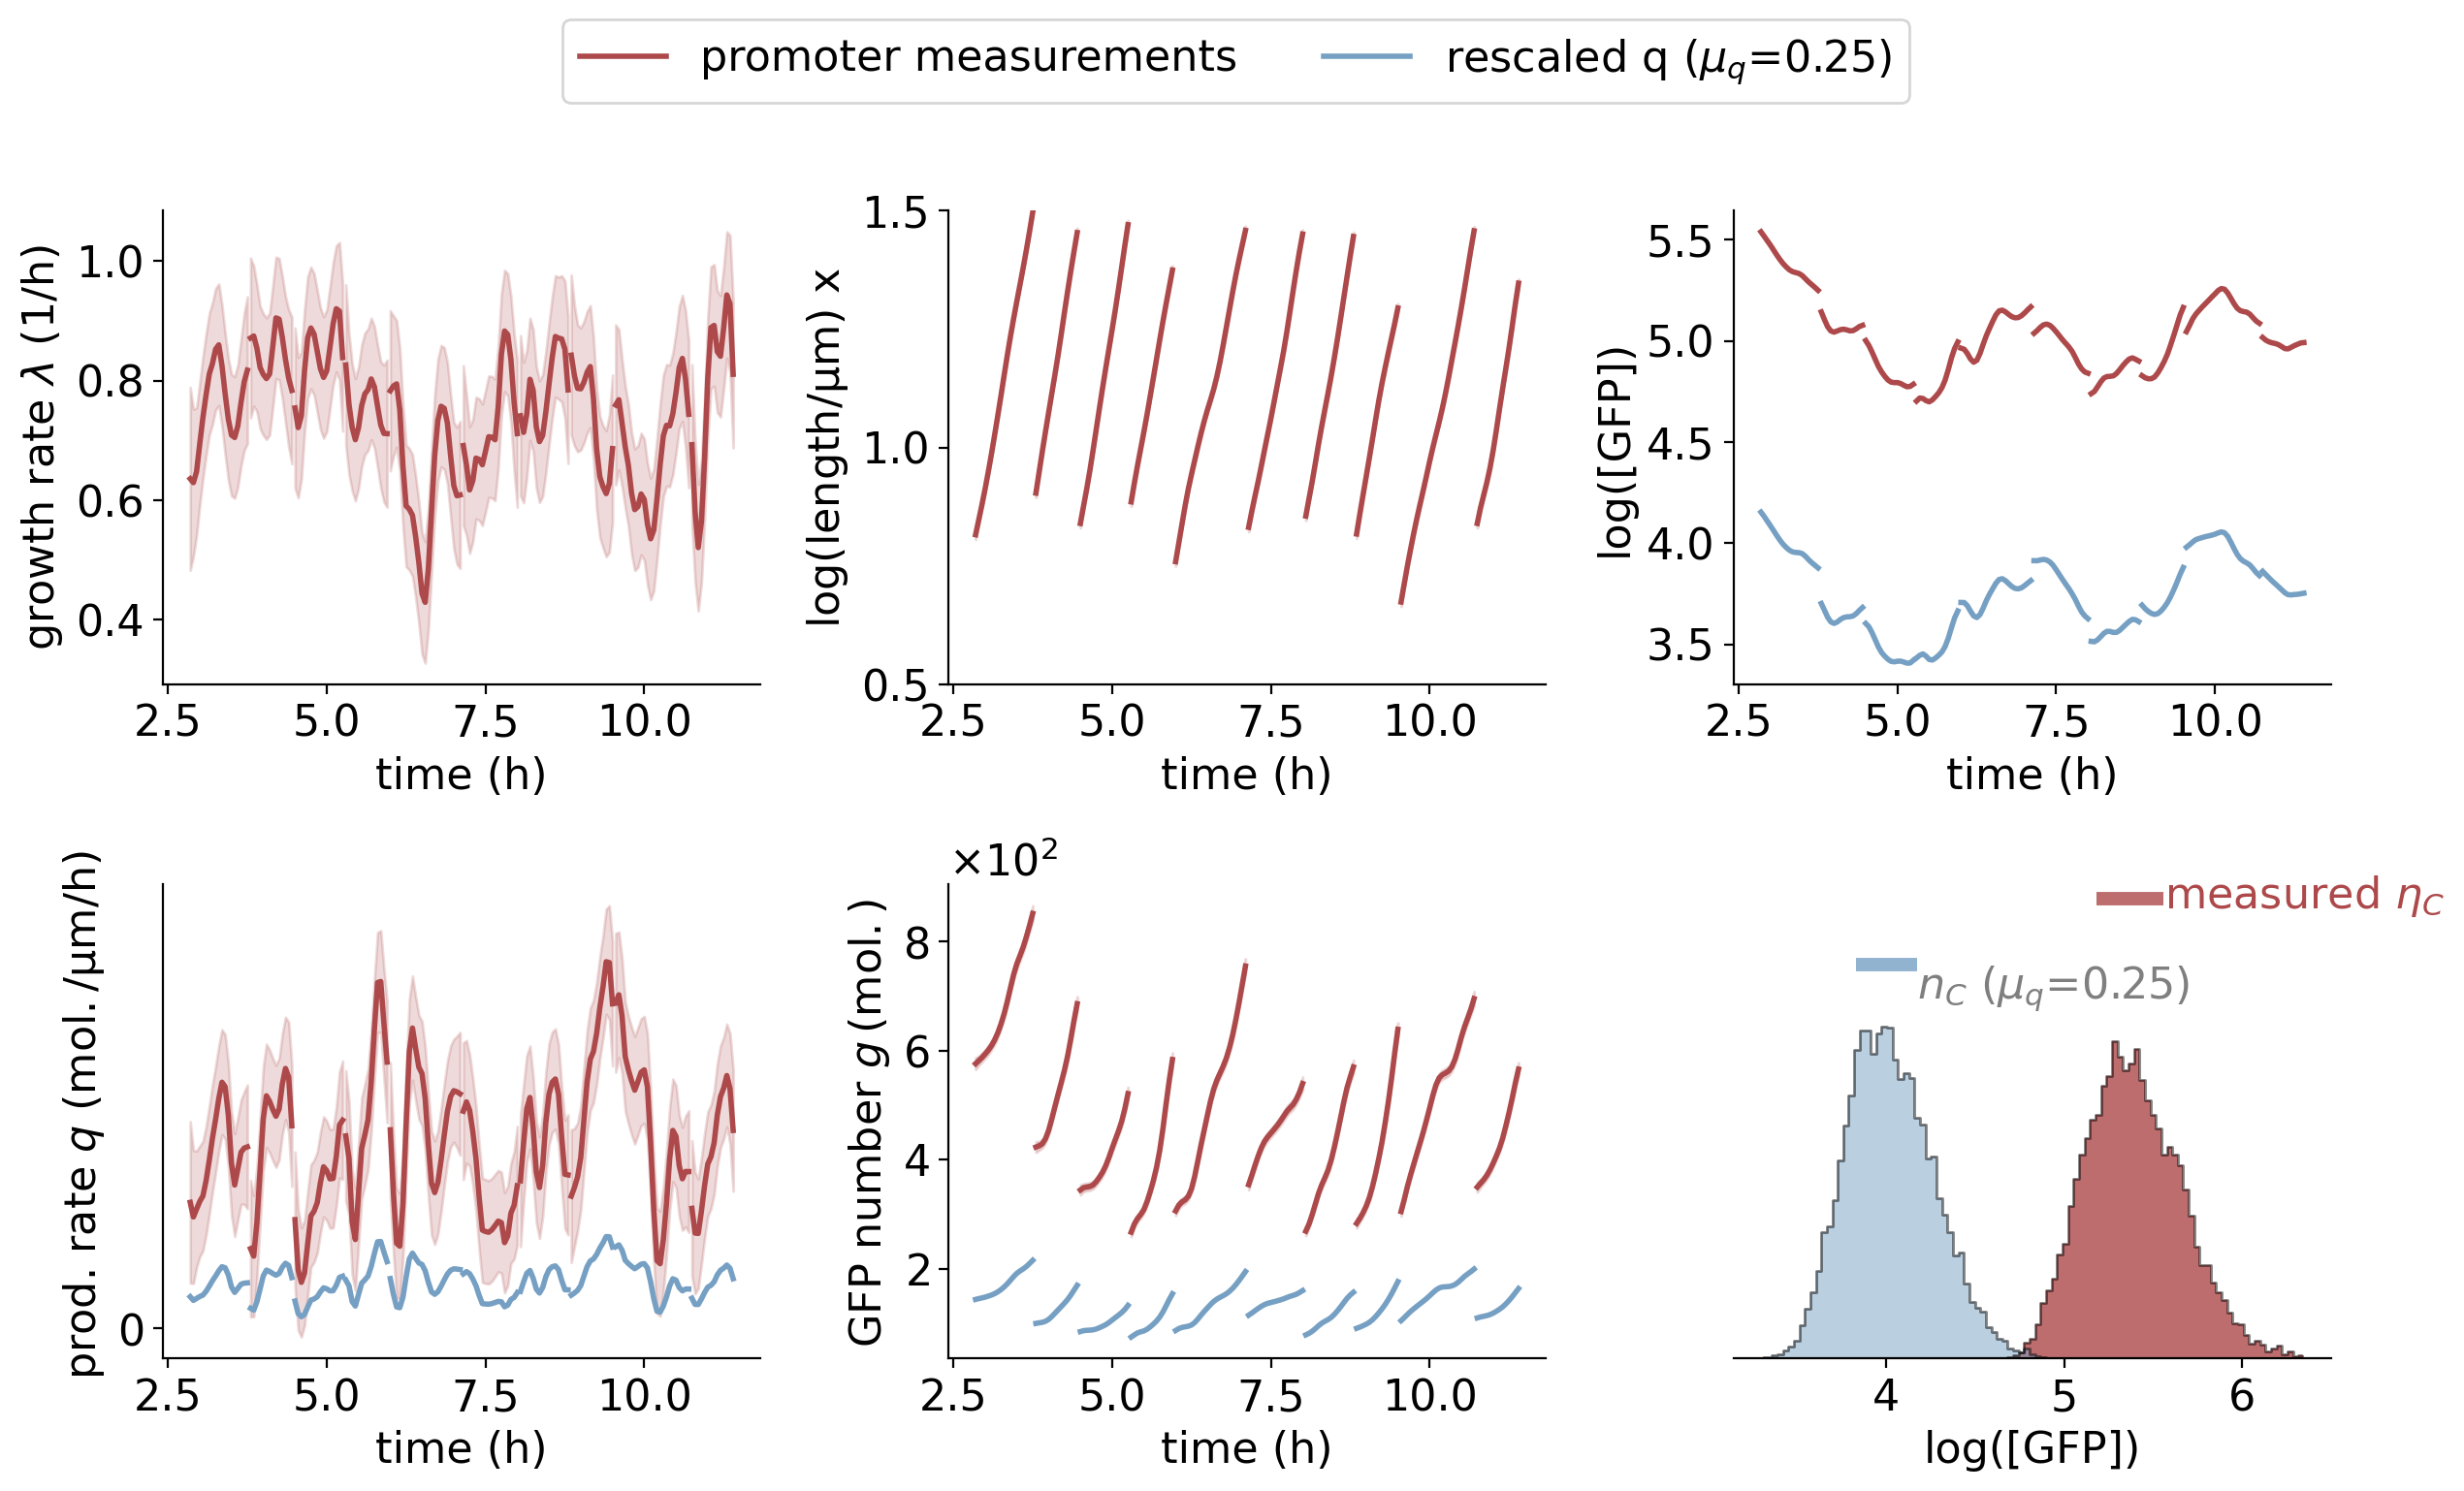

In [6]:
def plot_muq():
    sample_muq = "glucose020_med2_20190515"

    filename = "../../fluctuations_paper_data/integration/{:s}/0.25/{:s}_0.25.csv"
    cells_integrated = calc_log_concentration(df2cells(read_ggp_csv(filename.format(sample_muq, sample_muq)), qt="qt"))

    filename = "../../fluctuations_paper_data/mother_machine_data_sets/{:s}_autofl_corrected_f01234578910_b_prediction.csv"
    cells_data = calc_log_concentration(ggp_df2cells(read_ggp_csv(filename.format(sample_muq))))
        
    plot_predictions_vs_inegration(cells_data, 
                                   cells_integrated,
                                   get_longest_path(cells_data)[:10], 
                                    condition=get_condition(sample_muq),
                                    promoter=get_promoter(sample_muq),
                                    color_by = "promoter",
                                    ignore_errors=True, 
                                    plot_integrated=True, 
                                    label="rescaled q ($\\mu_q$=0.25)",
                                    iqr_text=r"$n_C$ ($\mu_q$=0.25)",
                                    plot_file="../../figures_for_fluctuations_paper/supp/scale_q_traces.pdf")

plot_muq()

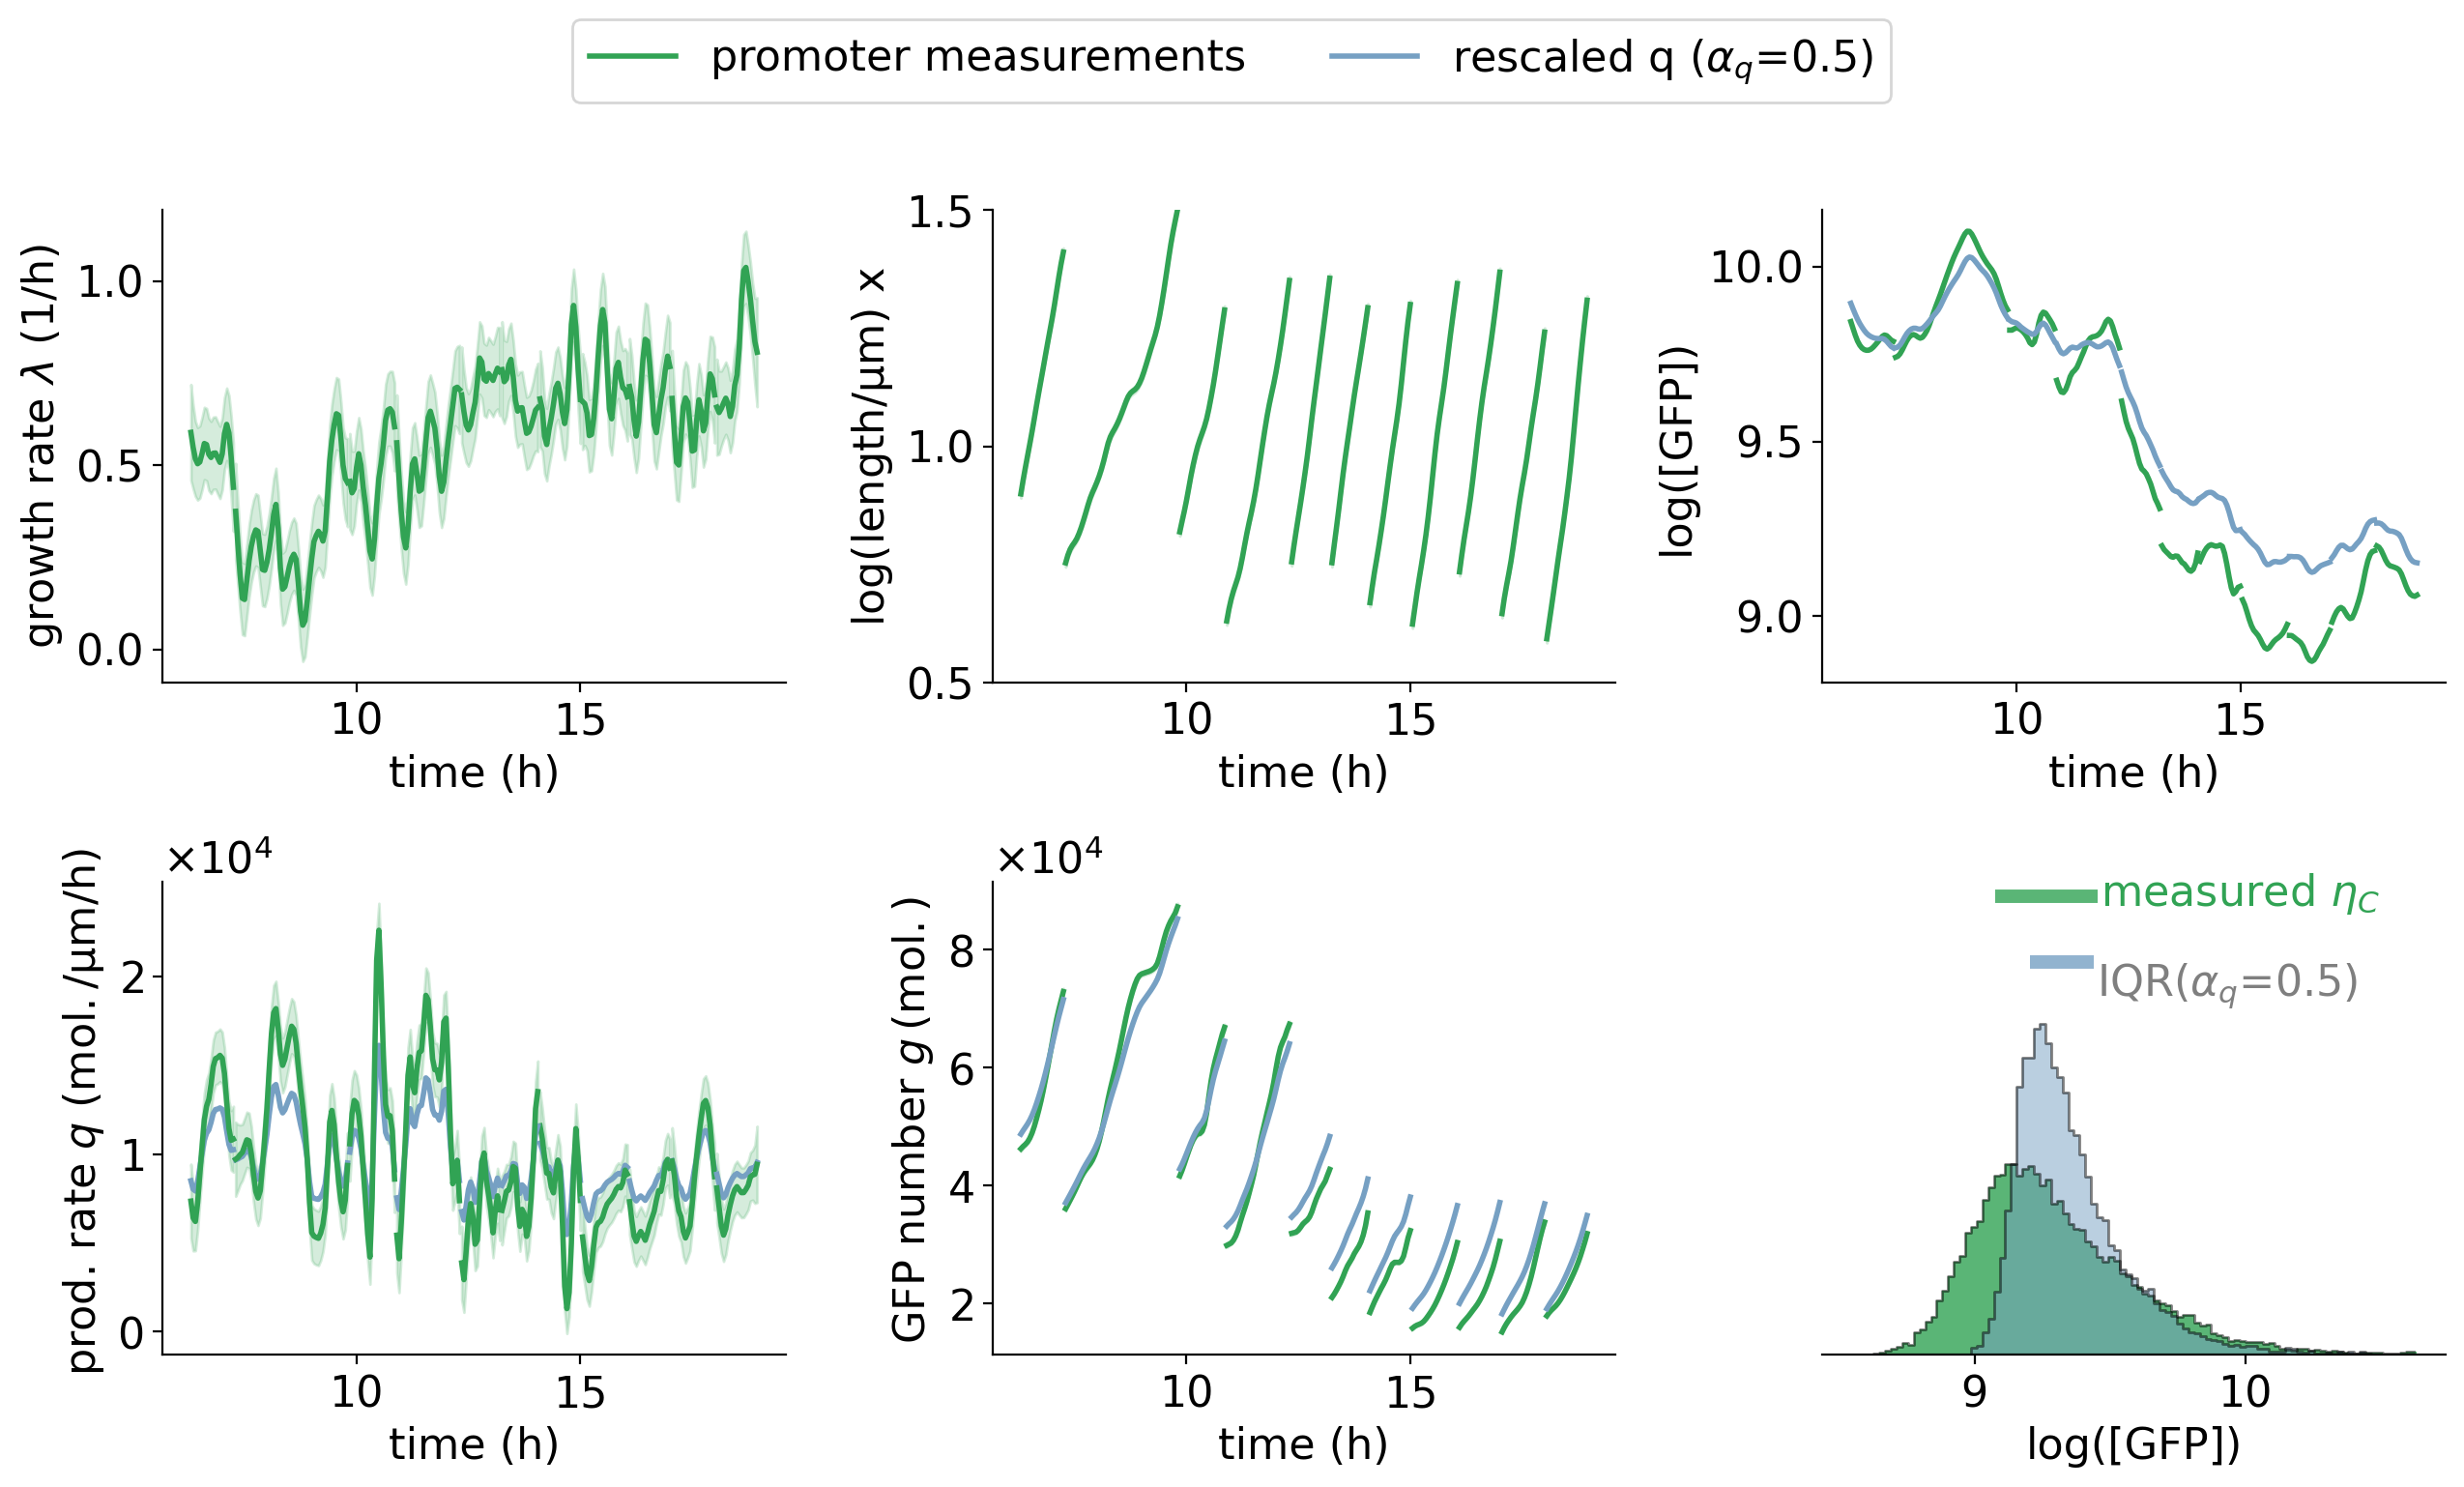

In [7]:

filename = "../../fluctuations_paper_data/integration/{:s}/dqs_0.5/{:s}_dqs_0.5.csv"
cells_integrated = calc_log_concentration(df2cells(read_ggp_csv(filename.format(sample, sample)), qt="qt"))


plot_predictions_vs_inegration(cells_data, 
                               cells_integrated,
                               path, 
                                condition=get_condition(sample),
                                promoter=get_promoter(sample),
                                color_by = "promoter",
                                ignore_errors=True, 
                                plot_integrated=True, 
                                label="rescaled q ($\\alpha_q$=0.5)",
                                iqr_text=r"$\mathrm{IQR}$($\alpha_q$=0.5)",
                                plot_file="../../figures_for_fluctuations_paper/supp/scale_dq_traces.pdf")

